In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import intersect1d
from datetime import datetime

# add ethereum to python path (only need to do this once)
import sys
sys.path.insert(0, "/home/ec2-user/SageMaker/ethereum")

from ethereum import (
    timestamp_to_datetime,
    EthereumData
)
from utils import (
    latest,
    lead_lag,
    add_latest_avail_block,
    lagged_block_data
)

from matplotlib.dates import DateFormatter, HourLocator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# import sys
# sys.path.insert(0, "/Users/tracy/masters/capstone/ethereum")

In [60]:
blocks = pd.read_csv("../data/blocks.csv").set_index('number')

In [74]:
pit = pd.read_csv("../data/pit_60_rob.csv").set_index('number')

In [61]:
blocks['datetime'] = pd.to_datetime(
    blocks['timestamp'],unit='s'
).dt.tz_localize('utc').dt.tz_convert('US/Eastern')
blocks['date'] = blocks['datetime'].dt.date

### Miner Trends

In [66]:
miner_counts = blocks[['date', 'miner']].reset_index().groupby(['miner', 'date']).count().unstack('miner')
miner_counts.index = pd.to_datetime(miner_counts.index)

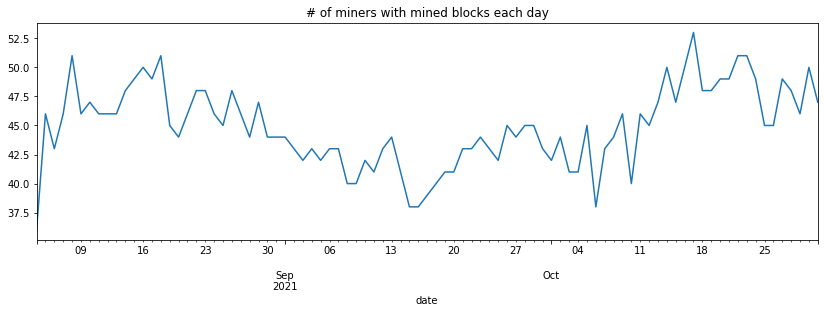

In [67]:
miner_counts.count(1).plot(
    title='# of miners with mined blocks each day',
    figsize=(14, 4)
);

In [68]:
miner_pct = miner_counts.div(miner_counts.sum(1), axis=0)
miner_pct.columns = miner_pct.columns.droplevel(0)

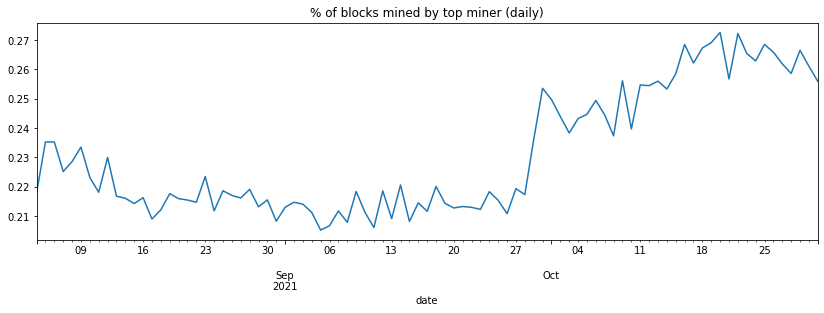

In [69]:
miner_pct.max(1).plot(
    title='% of blocks mined by top miner (daily)',
    figsize=(14, 4)
);

In [71]:
top_10_pct = miner_pct.quantile(0.9, 1)

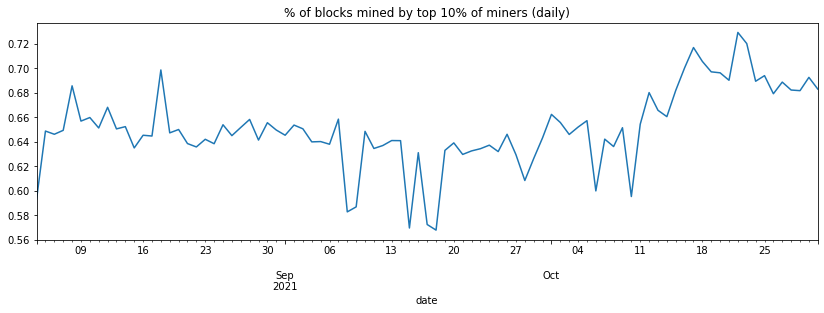

In [72]:
miner_pct[miner_pct.apply(lambda x: x >= top_10_pct)].sum(1).plot(
    title='% of blocks mined by top 10% of miners (daily)',
    figsize=(14, 4)
);

### Gas Trends

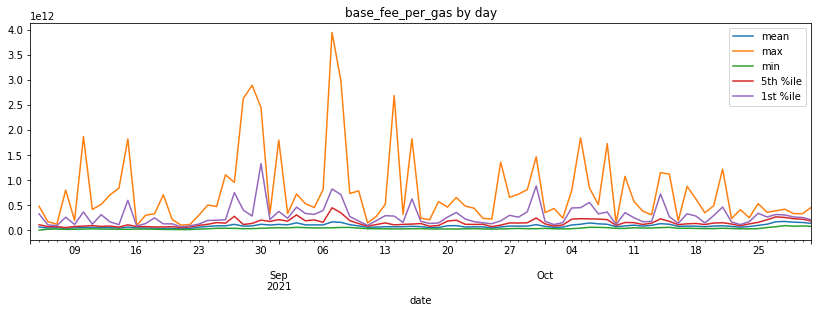

In [50]:
bspg_grouper = blocks[['date', 'base_fee_per_gas']].groupby(['date'])
bspg_data = pd.DataFrame({
    "mean" : bspg_grouper.mean()['base_fee_per_gas'],
    "max" : bspg_grouper.max()['base_fee_per_gas'],
    "min" : bspg_grouper.min()['base_fee_per_gas'],
    "5th %ile" : bspg_grouper.quantile(0.95)['base_fee_per_gas'],
    "1st %ile" : bspg_grouper.quantile(0.99)['base_fee_per_gas']
    #"std" : bspg_grouper.std()['base_fee_per_gas'],
})
bspg_data.index = pd.to_datetime(bspg_data.index)
bspg_data.plot(
    title='base_fee_per_gas by day',
    figsize=(14, 4)
);

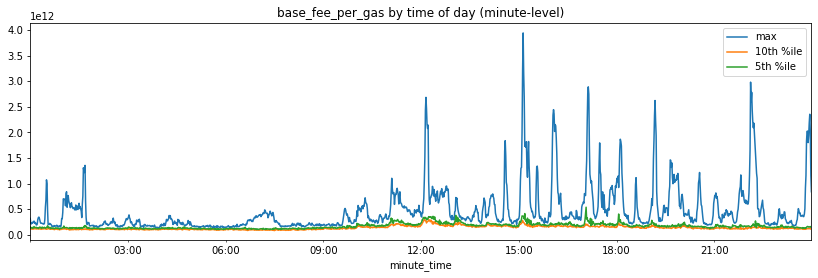

In [51]:
blocks['hour'] = blocks['datetime'].dt.hour
blocks['minute_time'] = blocks['datetime'].dt.floor('Min').dt.time

bspg_grouper = blocks[['minute_time', 'hour', 'base_fee_per_gas']].groupby(['minute_time'])
bspg_data = pd.DataFrame({
    #"mean" : bspg_grouper.mean()['base_fee_per_gas'],
    "max" : bspg_grouper.max()['base_fee_per_gas'],
    #"min" : bspg_grouper.min()['base_fee_per_gas'],
    "10th %ile" : bspg_grouper.quantile(0.9)['base_fee_per_gas'],
    "5th %ile" : bspg_grouper.quantile(0.95)['base_fee_per_gas']
    #"std" : bspg_grouper.std()['base_fee_per_gas'],
})
bspg_data.index = pd.to_datetime(bspg_data.index, format='%H:%M:%S')
ax = bspg_data.plot(
    title='base_fee_per_gas by time of day (minute-level)',
    figsize=(14, 4), 
)
ax.xaxis.set_major_locator(HourLocator(interval = 1))
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"));

In [52]:
start_hour = 2
end_hour = 9

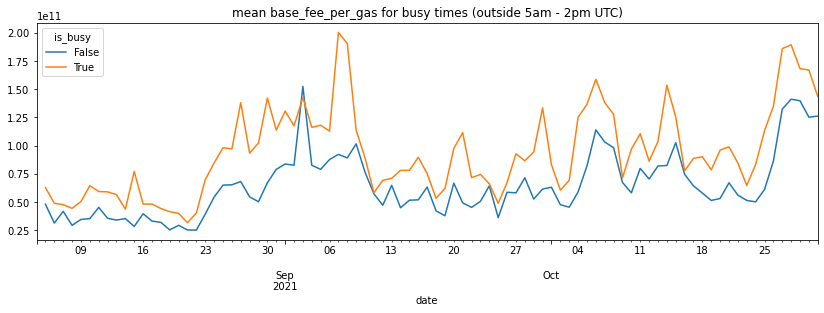

In [53]:
blocks['is_busy'] = (blocks['hour'] < start_hour) | (blocks['hour'] > end_hour)

busy_blocks = blocks[['base_fee_per_gas', 'is_busy', 'date']].groupby([
    'date', 'is_busy'
]).mean()['base_fee_per_gas'].unstack('is_busy')
busy_blocks.index = pd.to_datetime(busy_blocks.index)
busy_blocks.plot(
    title='mean base_fee_per_gas for busy times (outside 5am - 2pm UTC)',
    figsize=(14, 4), 
);

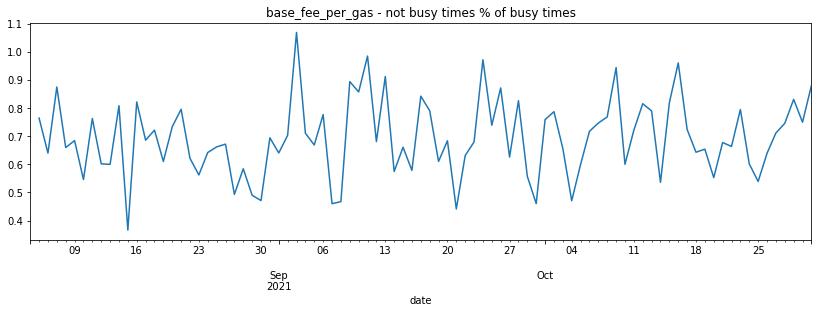

In [54]:
(busy_blocks[False] / busy_blocks[True]).plot(
    title='base_fee_per_gas - not busy times % of busy times',
    figsize=(14, 4), 
);
# this is fairly stable

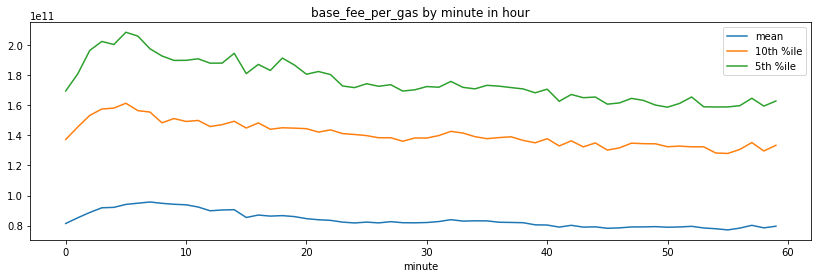

In [55]:
blocks['minute'] = blocks['datetime'].dt.minute

bspg_grouper = blocks[['minute', 'base_fee_per_gas']].groupby(['minute'])
bspg_data = pd.DataFrame({
    "mean" : bspg_grouper.mean()['base_fee_per_gas'],
    #"max" : bspg_grouper.max()['base_fee_per_gas'],
    #"min" : bspg_grouper.min()['base_fee_per_gas'],
    "10th %ile" : bspg_grouper.quantile(0.9)['base_fee_per_gas'],
    "5th %ile" : bspg_grouper.quantile(0.95)['base_fee_per_gas'],
    #"std" : bspg_grouper.std()['base_fee_per_gas'],
})
ax = bspg_data.plot(
    title='base_fee_per_gas by minute in hour',
    figsize=(14, 4), 
)

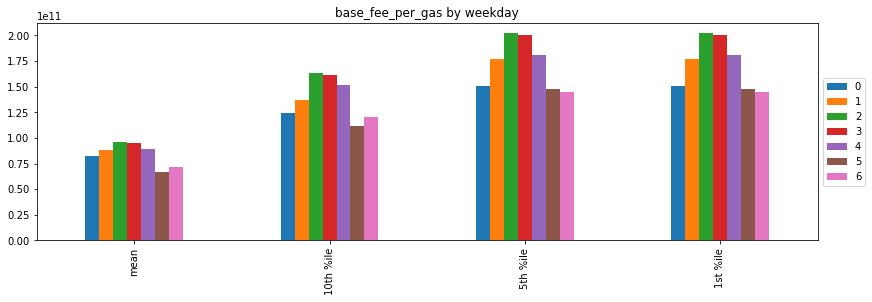

In [57]:
blocks['weekday'] = blocks['datetime'].dt.weekday
blocks['day_name'] = blocks['datetime'].dt.day_name()

bspg_grouper = blocks[['weekday', 'base_fee_per_gas']].groupby(['weekday'])
bspg_data = pd.DataFrame({
    "mean" : bspg_grouper.mean()['base_fee_per_gas'],
    #"max" : bspg_grouper.max()['base_fee_per_gas'],
    #"min" : bspg_grouper.min()['base_fee_per_gas'],
    "10th %ile" : bspg_grouper.quantile(0.9)['base_fee_per_gas'],
    "5th %ile" : bspg_grouper.quantile(0.95)['base_fee_per_gas'],
    "1st %ile" : bspg_grouper.quantile(0.95)['base_fee_per_gas'],
    #"std" : bspg_grouper.std()['base_fee_per_gas'],
})
ax = bspg_data.transpose().plot.bar(
    title='base_fee_per_gas by weekday',
    figsize=(14, 4), 
).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Time-Series Model

In [73]:
pit['latest_avail_block'] = pit['latest_avail']

NameError: name 'pit' is not defined

In [552]:
x_vars_raw = blocks[['hour', 'minute', 'weekday', 'base_fee_per_gas']]
x_vars_raw = x_vars_raw.loc[~x_vars_raw.index.isna()]
x_vars_lagged = lagged_block_data(x_vars_raw, pit).dropna()

In [553]:
x_vars_lagged['chg'] = x_vars_lagged['base_fee_per_gas_lagged'].diff()

In [441]:
# predict change based on hour/minute/weekday

#### Simple in-sample linear model using dummy variables

In [442]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [554]:
lr_y = x_vars_lagged['chg'].dropna()
lr_x = x_vars_lagged[['hour_lagged', 'minute_lagged', 'weekday_lagged']].loc[lr_y.index]

# https://stackoverflow.com/questions/50733014/linear-regression-with-dummy-categorical-variables
lr_x_dummies = pd.get_dummies(data=lr_x.astype(str), drop_first=True)

In [555]:
lr = LinearRegression() 
lr.fit(lr_x_dummies, lr_y)
lr.score(lr_x_dummies, lr_y)

0.0014178253239659488

In [556]:
lr_pred = lr.predict(lr_x_dummies)
mean_squared_error(lr_y, lr_pred)

7.735539184786804e+19

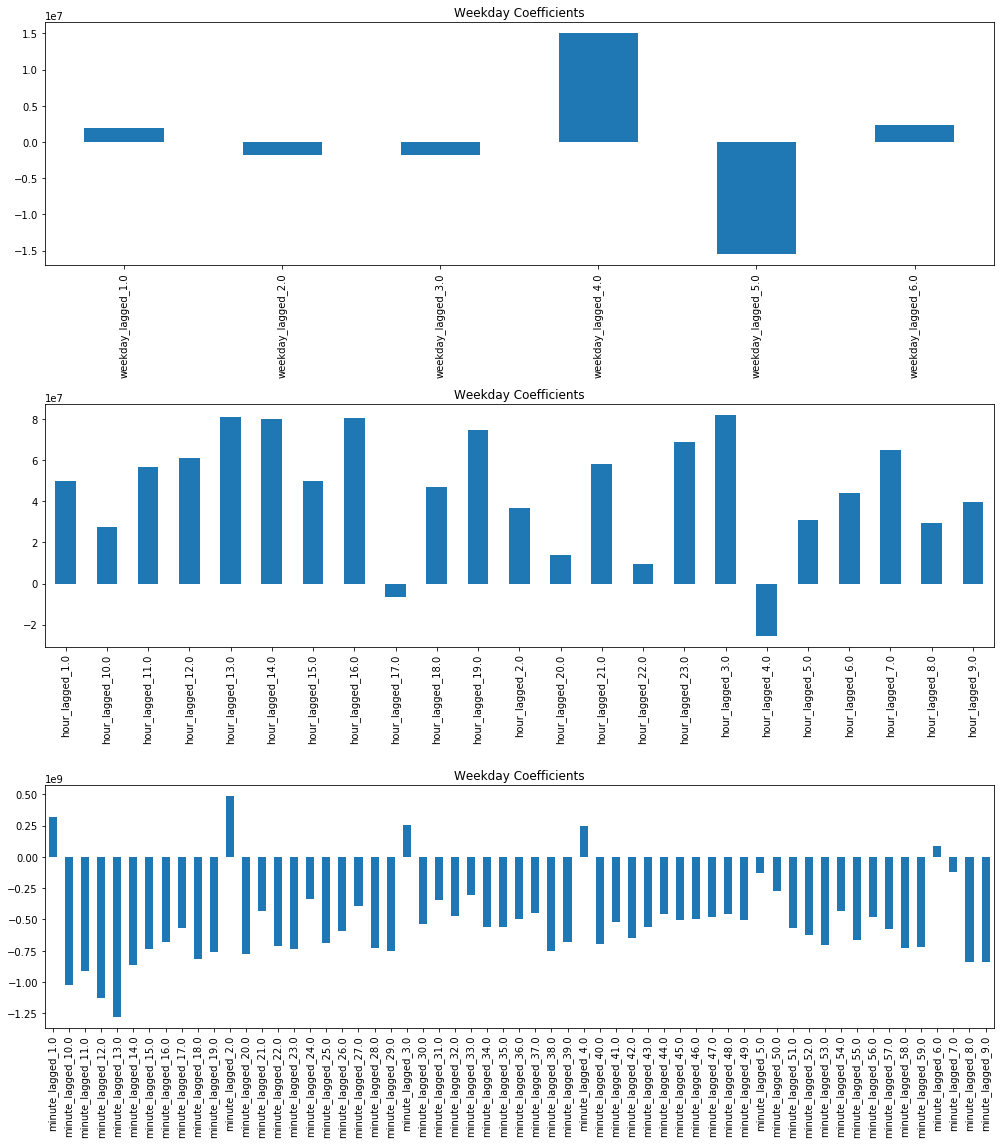

In [557]:
fig, axes = plt.subplots(3, 1, figsize=(14, 16))
pd.Series(lr.coef_, index=lr_x_dummies.columns).filter(like='weekday').plot.bar(
    title='Weekday Coefficients', ax=axes[0]
)
pd.Series(lr.coef_, index=lr_x_dummies.columns).filter(like='hour').plot.bar(
    title='Weekday Coefficients', ax=axes[1]
)
pd.Series(lr.coef_, index=lr_x_dummies.columns).filter(like='minute').plot.bar(
    title='Weekday Coefficients', ax=axes[2]
)
fig.tight_layout()

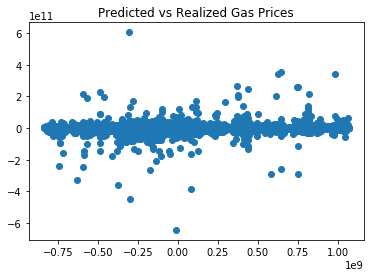

In [559]:
sample_results = pd.DataFrame({"pred" : lr_pred, "realized" : lr_y}).sample(75000)
plt.scatter(sample_results['pred'], sample_results['realized'])
plt.title('Predicted vs Realized Gas Prices');

In [561]:
lr_pred_chg = pd.Series(lr_pred, index=lr_x.index)
lr_pred_level = pd.Series(x_vars_lagged['base_fee_per_gas_lagged'] + lr_pred_chg, name='pred_base_fee_per_gas')

In [602]:
lr_pred_comparison = pd.concat([
    lr_pred_level, 
    x_vars_raw['base_fee_per_gas'],
    blocks['datetime']
], axis=1).dropna()
lr_pred_comparison['datetime'] = pd.to_datetime(lr_pred_comparison['datetime'])
lr_pred_comparison['diff'] = lr_pred_comparison['pred_base_fee_per_gas'] - lr_pred_comparison['base_fee_per_gas']

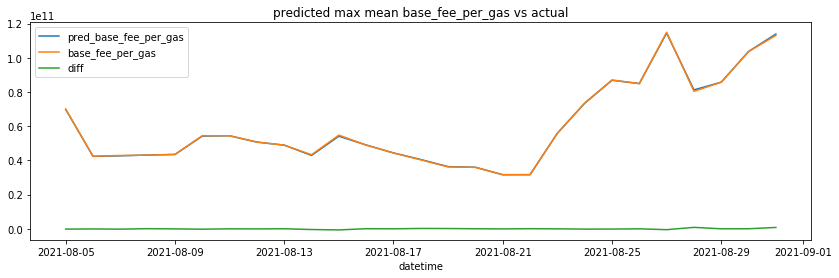

In [622]:
lr_pred_comparison.groupby(lr_pred_comparison['datetime'].dt.date).mean().plot(
    title="predicted max mean base_fee_per_gas vs actual",
    figsize=(14, 4)
);

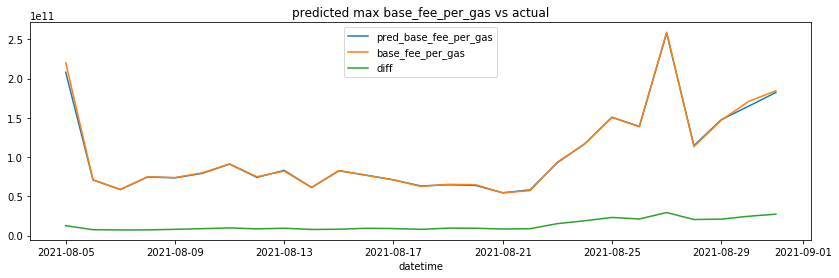

In [621]:
lr_pred_comparison.groupby(lr_pred_comparison['datetime'].dt.date).quantile(0.95).drop(columns='datetime').plot(
    title="predicted max base_fee_per_gas vs actual",
    figsize=(14, 4)
);

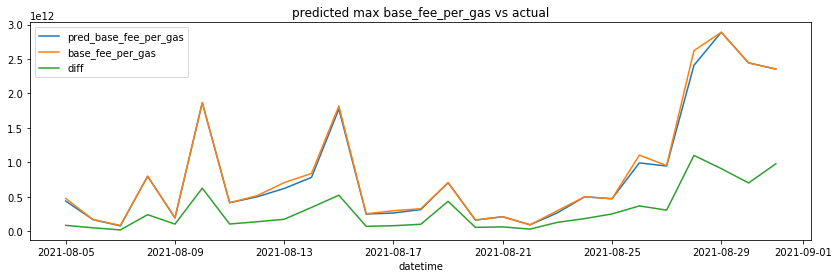

In [620]:
lr_pred_comparison.groupby(lr_pred_comparison['datetime'].dt.date).max().drop(columns='datetime').plot(
    title="predicted max base_fee_per_gas vs actual",
    figsize=(14, 4)
);

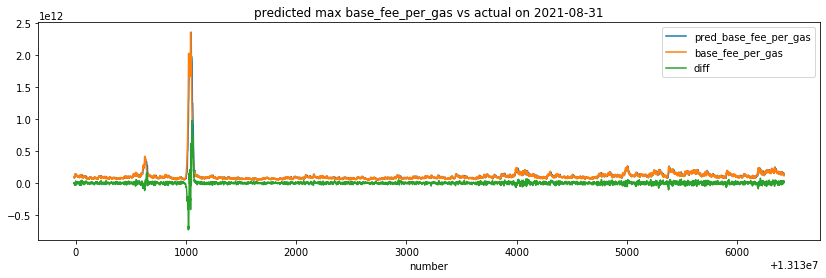

In [648]:
dt = '2021-08-31'
lr_pred_comparison[
    (lr_pred_comparison['datetime'].dt.date == pd.to_datetime(dt))
].drop(columns='datetime').plot(
    title=f"predicted max base_fee_per_gas vs actual on {dt}",
    figsize=(14, 4)
);